In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from colorspacious import cspace_converter
from collections import OrderedDict

ModuleNotFoundError: No module named 'colorspacious'

In [2]:
data1 = pd.read_csv("data1.csv")

# "abb14" and "ultimo_ing.x" are droped due to their NaN values
data1.drop(["Unnamed: 0", "abb14", "ultimo_ing.x"], axis = 1, inplace = True)
data1.head()

,codcliente,si2014,abb13
0,100005,0,2013-01-27
1,100006,1,2013-01-14
2,100007,0,2012-12-05
3,100017,1,2012-12-10
4,100020,0,2012-12-09


In [3]:
an13 = pd.read_csv("an13.csv", na_values = "NA", encoding = "latin1")

an13.drop(["Unnamed: 0", "professione"], axis = 1, inplace = True)
an13.drop(["sconto", "riduzione","agenzia","cap"], axis = 1, inplace = True)

# Convert "data di nascita" into age at the end of year 2013.
# Before it was necessary to replace 2 values that had "-" with
# the median of the overall year of birth distribution (=1959).
an13["data_nascita"] = [int(x) if "-" not in x else 1959 for x in an13["data_nascita"]]
an13["age"] = [2013-x for x in an13["data_nascita"]]

# "nuovo_abb" is alrady dichotomous and with full values. Just convert it into 0/1
an13["nuovo_abb"] = [1 if x == "NUOVO ABBONATO" else 0 for x in an13["nuovo_abb"]]

# "sesso" has missing values. We filled the according to the distribution of non-NaN values
count_sex = an13["sesso"].value_counts(normalize=True)
missing_sex = an13["sesso"].isnull()
an13.loc[an13["sesso"].isnull(),"sesso"] = np.random.choice(count_sex.index,
                                                            size = len(an13[missing_sex]),
                                                            p = count_sex.values)

# Then the 0/1 variable is created according to sex (female = 1)
an13["femmina"] = [1 if x == "F" else 0 for x in an13["sesso"]]
# Tipo_pag is converted into 4 dummies
an13 = pd.concat([an13, pd.get_dummies(an13["tipo_pag"], drop_first = True)], axis = 1)
an13.drop(["sesso","tipo_pag","data_nascita"], axis = 1, inplace = True)

an13.head()

,codcliente,data_inizio,importo,agenzia_tipo,comune,nuovo_abb,age,femmina,BANCOMAT,CARTA DI CREDITO,CONTANTI,NESSUN PAGAMENTO
0,90095,09/12/2012 00:00,28,PUNTO INFORMATIVO,TORINO,1,28,0,0,0,1,0
1,89662,06/01/2013 00:00,28,PUNTO INFORMATIVO,TORINO,1,28,0,0,0,1,0
2,202278,27/01/2013 00:00,28,PUNTO INFORMATIVO,TORINO,1,21,0,1,0,0,0
3,269895,02/12/2012 00:00,28,PUNTO COMMERCIALE,SVIZZERA,1,27,0,0,0,1,0
4,88177,26/01/2013 00:00,28,PUNTO INFORMATIVO,TORINO,1,30,0,0,0,1,0


In [4]:
# The following dataset, created from a .json file, is needed to
# reduce the dimensionality of the column "comune".
comunes = pd.read_csv("comuni_done.csv", sep=";")
comunes.drop(["Unnamed: 0", "codice","zona__codice","zona__nome",
              "regione__codice","regione__nome","provincia__codice","provincia__nome",
              "codiceCatastale","popolazione"], axis = 1, inplace = True)
comunes["nome"] = comunes["nome"].str.upper()
comunes.rename({"nome": "comune"}, axis = 1, inplace = True)

# We performed a merge on the column "comune" of an13 dataframe,
# then we adjusted the result by creating a dictionary with the unmatched
# values of that column (mainly foreign countries).
an13 = an13.merge(comunes, how = "left", on = "comune")
unmatched_dict = {"FP":["SVIZZERA","DATO MANCANTE","SPAGNA","FRANCIA","GERMANIA",
                        "CHATILLON","BOLZANO/BOZEN","MONTORO INFERIORE","ARGENTINA",
                        "CAGNO","LANZO D'INTELVI","ANTEY-SAINT-ANDRÈ","HONE","RIVIGNANO",
                        "PRÈ-SAINT-DIDIER","NEGRAR","MONTORO SUPERIORE","MONACO","BELGIO",
                        "DUINO-AURISINA","CINA REPUBBLICA POPOLARE","LARI","LU","SAVIGNO",
                        "SANTO STINO DI LIVENZA","FIGLINE VALDARNO","CAPACCIO","PAESI BASSI",
                        "GRESSONEY LA TRINITE'","BREMBILLA","COLBORDOLO","STATI UNITI D'AMERICA",
                        "ROMANIA","LUSSEMBURGO","MESSICO"],
                  "TO":["LEINÌ","VICO CANAVESE","CAMPIGLIONE-FENILE","ALICE SUPERIORE","PECCO"]}

# The following column is to replace NaN values of "sigla" according to the
# dictionary above, and eventually to reduce its dimensionality to 3
def provs(col):
    col = list(col)
    l = []
    for x in range(len(col)):
        if type(col[x]) != str:
            if an13.loc[x]["comune"] in unmatched_dict["FP"]: l += ["FP"]
            elif an13.loc[x]["comune"] in unmatched_dict["TO"]: l += ["TO"]
            else: l += ["PI"]
        else: l += [ col[x] ]
    m = []
    for el in l:
        if el in ["AL","AT","BI","CN","NO","VB","VC"]: m += ["PI"]
        elif el == "TO": m += [el]
        else: m += ["FP"]    
    return m

an13["sigla"] = provs(an13["sigla"])
# From the updated column "sigla" it was possible to create
# the dummies and attached them on the right side of an13.
an13 = pd.concat([an13, pd.get_dummies(an13["sigla"], drop_first = True)], axis = 1)
an13.drop(["comune","sigla"], axis = 1, inplace = True)

# Finally, the last column whose dimensionality needed a reduction was 
# "agenzia_tipo", that was broken down into 5 aspects based on conceptual
# clusters of the original values. Then the column is added to "an13" and dropped
def reduce_agency(col):
    l = []
    for x in col:
        if x in ["PUNTO INFORMATIVO","DATO MANCANTE","PUNTO COMMERCIALE"]:
            l += ["PUNTO INFORMATIVO/COMMERCIALE/NAN"]
        elif x in ["MUSEO","TEATRI","EDICOLE"]:
            l += ["MUSEO/TEATRI/EDICOLE"]
        elif x in ["OFFERTA SCUOLE","OFFERTA AZIENDA","GRUPPO D'ACQUISTO"]:
            l += ["OFFERTE/GRUPPI"]
        elif x == "ACQUISTO ONLINE":
            l += ["ACQUISTO ONLINE"]
        else:
            l += ["CRAL/TESSERE ORO/ASSOCIAZIONE"]
    return l

an13["agenzia_tipo"] = reduce_agency(an13["agenzia_tipo"])

an13 = pd.concat([an13, pd.get_dummies(an13["agenzia_tipo"], drop_first = True)], axis = 1)
an13.drop(["agenzia_tipo"], axis = 1, inplace = True)

# At last, we created the column of the day of the year
# in which a customer purchased their subscription.
an13["data_inizio"] = pd.to_datetime(an13["data_inizio"], format = "%d/%m/%Y %H:%M")
an13["day_y_purchase"] = [int(x.strftime('%j')) for x in an13["data_inizio"]]
an13.drop("data_inizio", axis = 1, inplace = True)

In [5]:
in13 = pd.read_csv("in13.csv", na_values = "NA")
in13.drop("Unnamed: 0", axis = 1, inplace = True)
in13.rename({"CodCliente": "codcliente"}, axis = 1, inplace = True)

un_mus = pd.read_excel("unallocated_museums.xlsx")
in13 = in13.merge(un_mus, how = "left", on = "museo")
in13.drop(["comune.museo","prov.museo"], axis = 1, inplace = True)
in13.head()

,datai,orai,importo,museo,prov_museo,com_museo,codcliente,tipo.museo
0,01/12/2012,10:10,7.5,REGGIA DI VENARIA REALE,TO,VENARIA REALE,46715,Storia
1,01/12/2012,10:11,5.0,REGGIA DI VENARIA REALE,TO,VENARIA REALE,46715,Storia
2,01/12/2012,10:11,7.5,REGGIA DI VENARIA REALE,TO,VENARIA REALE,133015,Storia
3,01/12/2012,10:12,5.0,REGGIA DI VENARIA REALE,TO,VENARIA REALE,133015,Storia
4,01/12/2012,10:18,2.5,MUSEO DELLA FRUTTA,TO,TORINO,80732,Arte


In [6]:
# From "in13", we've built a new dataframe with the following columns:
# - codcliente
# - frequenza: number of times every customer went to museums
# - variety: how many different museums they have visited
# - passione: given different museum's categories, this score measures how many times a customer
#             prefers a category. If they did only one visit, the score is set just below the 0.8 thershold
# - appassionato: takes the "passione" scores into a dichotomous variable at a 0.8 threshold.
#                 The result is that only 20% of the customer is defined as passionate, which may be closed to reality

in13_custom = pd.DataFrame({"codcliente":pd.DataFrame(in13["codcliente"].value_counts()).index,
                            "frequenza":pd.DataFrame(in13["codcliente"].value_counts())["codcliente"]})
                            
in13_custom["variety"] = [ len( in13[in13["codcliente"] == x]["museo"].unique() )
                          for x in in13_custom["codcliente"] ]

in13_custom["passione"] = [ (in13[in13["codcliente"] == x]["tipo.museo"].value_counts()[0])/(in13_custom[in13_custom["codcliente"] == x]["frequenza"].values[0] )
                           for x in in13_custom["codcliente"] ]

in13_custom["passione"] = [in13_custom.loc[x]["passione"] if in13_custom.loc[x]["frequenza"] > 1 else 0.79
                           for x in in13_custom["codcliente"] ]

in13_custom["appassionato"] = [1 if x >= 0.8 else 0 for x in in13_custom["passione"] ]

in13_custom

,codcliente,frequenza,variety,passione,appassionato
219314,219314,264,66,0.477273,0
48954,48954,179,79,0.329609,0
185108,185108,124,30,0.370968,0
172643,172643,101,20,0.534653,0
132550,132550,94,24,0.606383,0
...,...,...,...,...,...
109849,109849,1,1,0.790000,0
258105,258105,1,1,0.790000,0
233525,233525,1,1,0.790000,0
91392,91392,1,1,0.790000,0


# Explorative Data Analysis

## Data 1

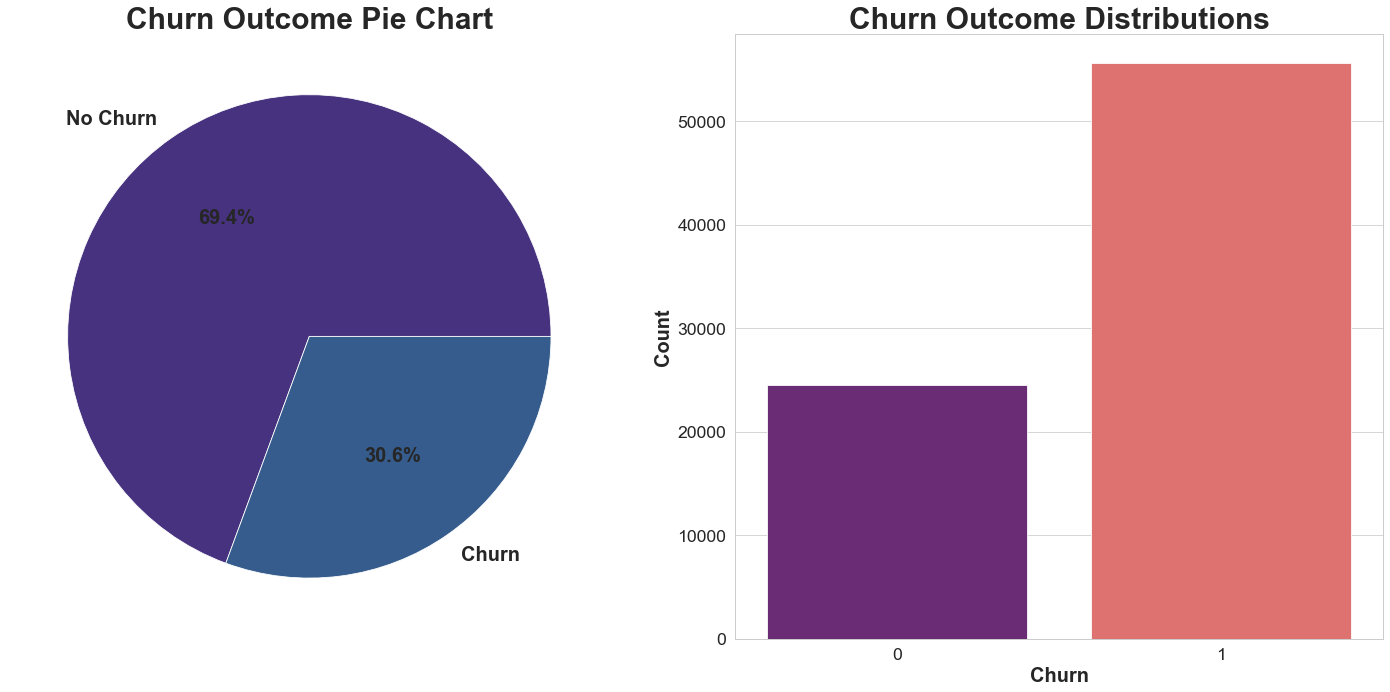

In [83]:
sns.set(style = 'whitegrid', palette = 'viridis')
sns.set_context('paper', font_scale = 2)
fig = plt.figure(figsize = (20, 10))
plt.subplot(121)
plt.pie(data1.si2014.value_counts(),labels = ['No Churn', 'Churn'], autopct = '%.1f%%', radius = 1, textprops={'fontsize': 20, 'fontweight': 'bold'})
plt.title('Churn Outcome Pie Chart', fontsize = 30, fontweight = 'bold')
plt.subplot(122)
t = sns.countplot(data1.si2014, palette= 'magma')
t.set_xlabel('Churn', fontweight = 'bold', fontsize = 20)
t.set_ylabel('Count', fontweight = 'bold', fontsize = 20)
plt.title('Churn Outcome Distributions', fontsize = 30, fontweight = 'bold')
plt.tight_layout()

## In13

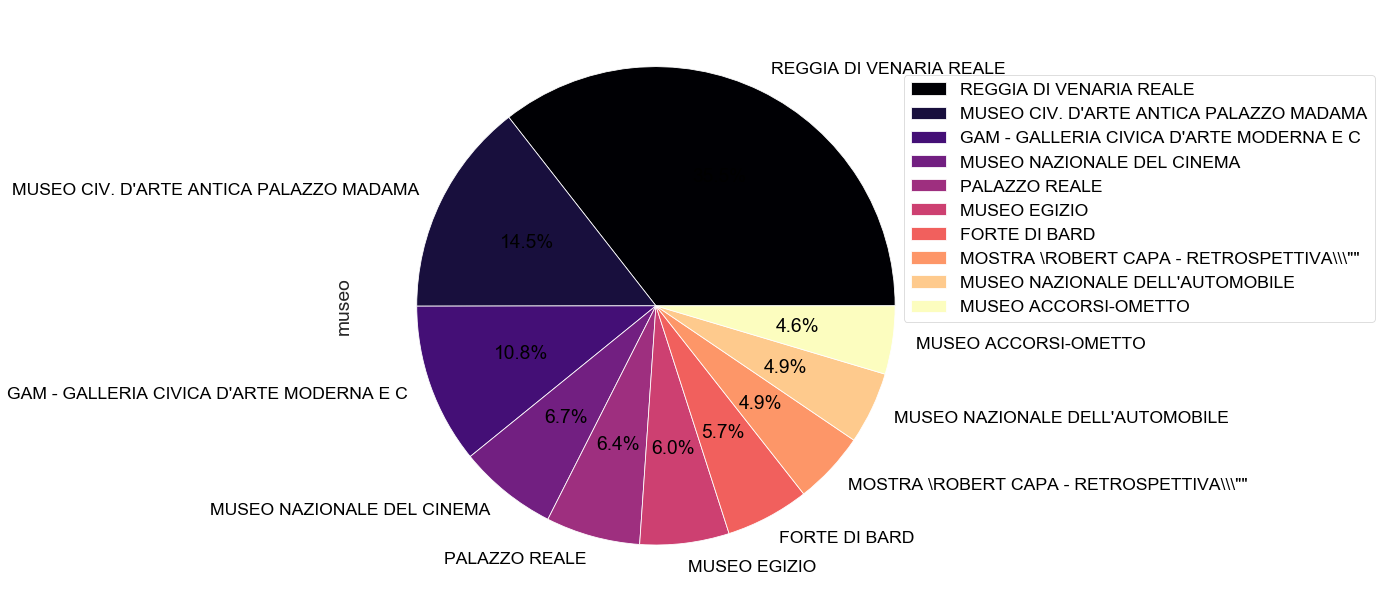

In [68]:
# https://python-graph-gallery.com/197-available-color-palettes-with-matplotlib/
in13["museo"].value_counts().head(10).plot(kind = 'pie', 
                                           autopct='%1.1f%%',
                                           figsize=(11, 11),
                                           cmap = 'magma').legend(loc='best', bbox_to_anchor=(0.9, 0.9))

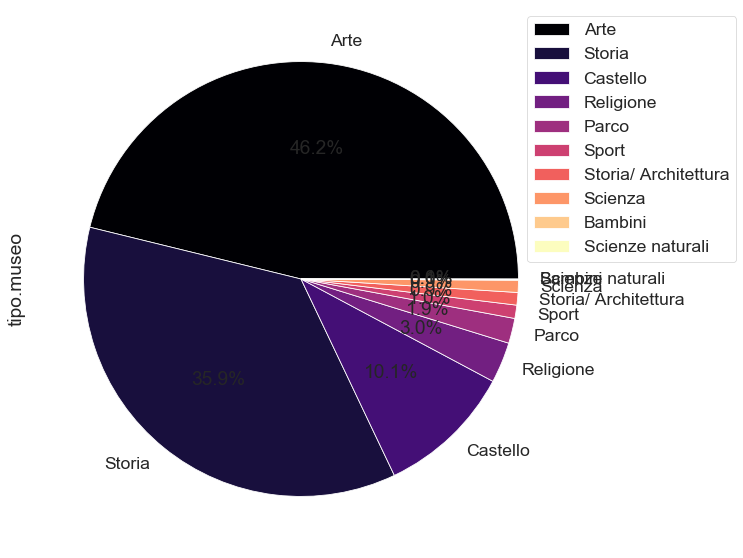

In [88]:
in13["tipo.museo"].value_counts().head(10).plot(kind = 'pie', 
                                           autopct='%1.1f%%',
                                           figsize=(10, 10),
                                           cmap = 'magma').legend(loc='best', bbox_to_anchor=(0.9, 1.0))

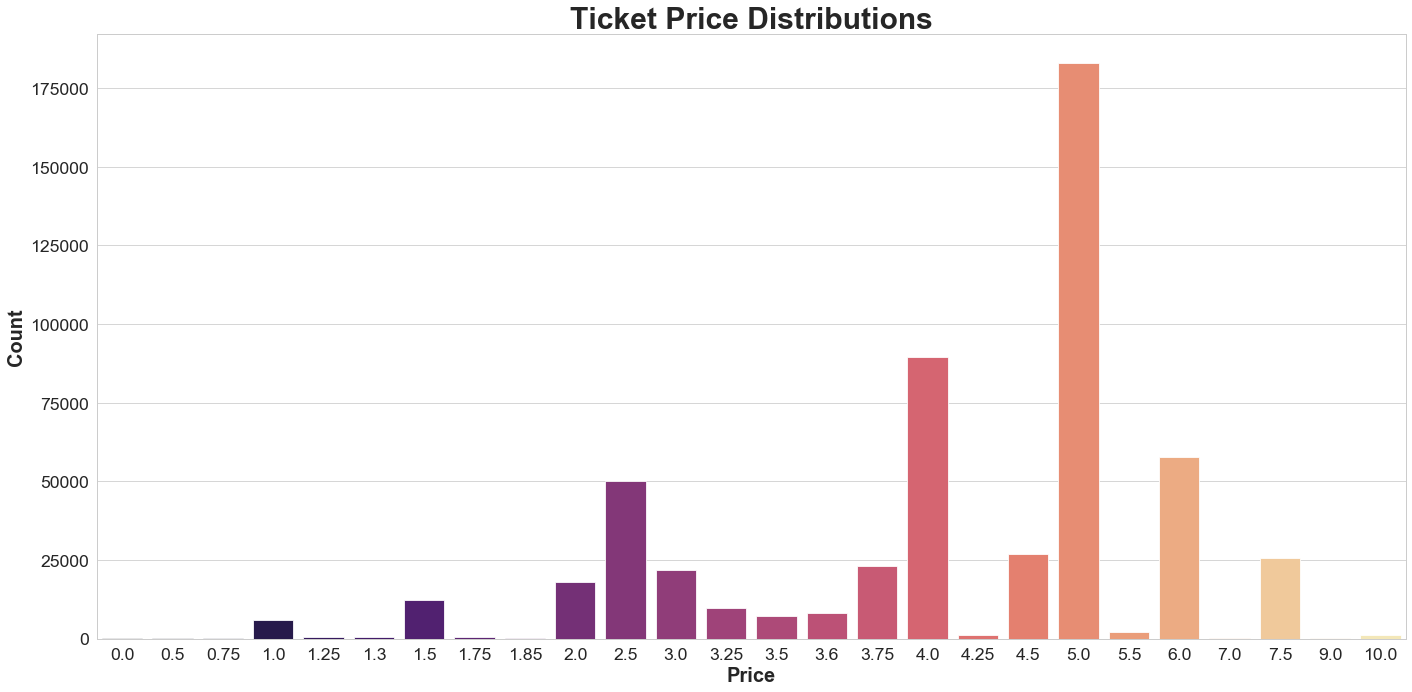

In [43]:
sns.set(style = 'whitegrid')
sns.set_context('paper', font_scale = 2)
sns.color_palette("magma")
fig = plt.figure(figsize = (20, 10))
price = sns.countplot(in13.importo, palette= 'magma')
price.set_xlabel('Price', fontweight = 'bold', fontsize = 20)
price.set_ylabel('Count', fontweight = 'bold', fontsize = 20)
plt.title('Ticket Price Distributions', fontsize = 30, fontweight = 'bold')
plt.tight_layout()

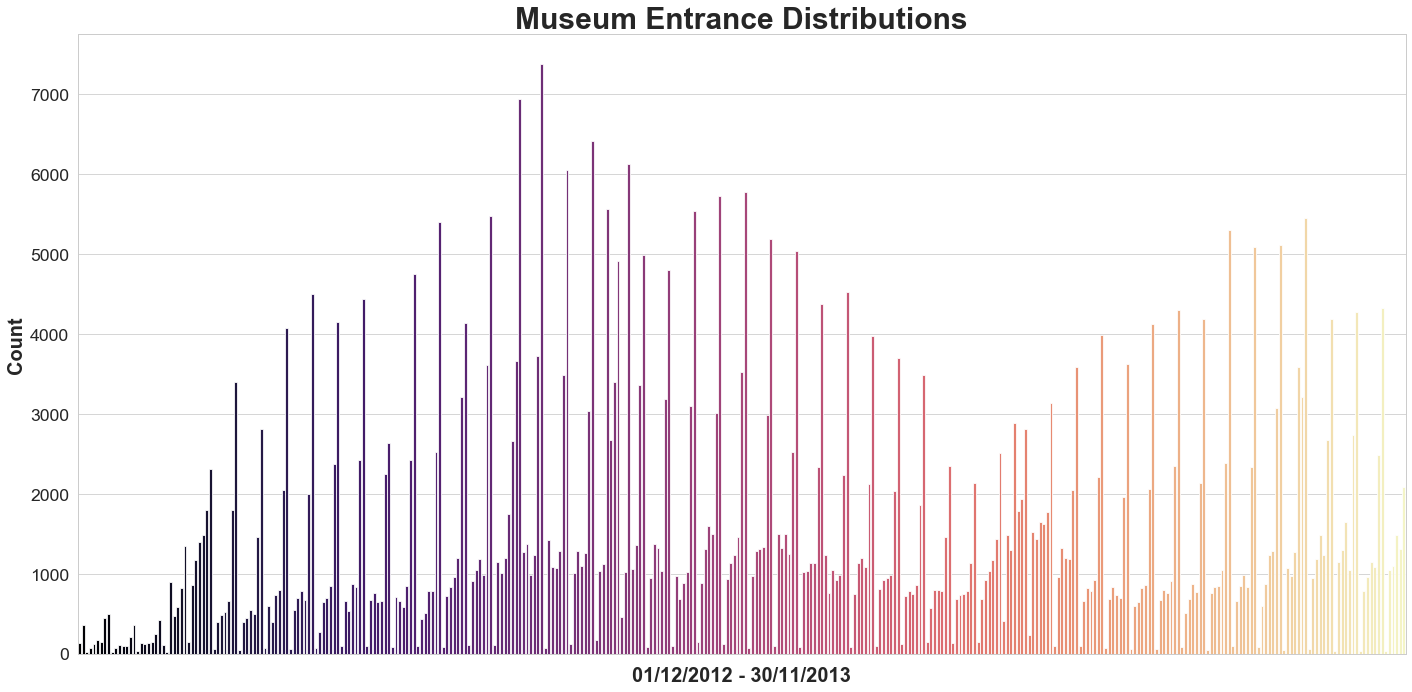

In [42]:
sns.set(style = 'whitegrid')
sns.set_context('paper', font_scale = 2)
fig = plt.figure(figsize = (20, 10))
date = sns.countplot(in13.datai, palette= 'magma')
date.set(xticklabels=[])
date.set_xlabel('01/12/2012 - 30/11/2013', fontweight = 'bold', fontsize = 20)
date.set_ylabel('Count', fontweight = 'bold', fontsize = 20)
plt.title('Museum Entrance Distributions', fontsize = 30, fontweight = 'bold')
plt.tight_layout()

## an13

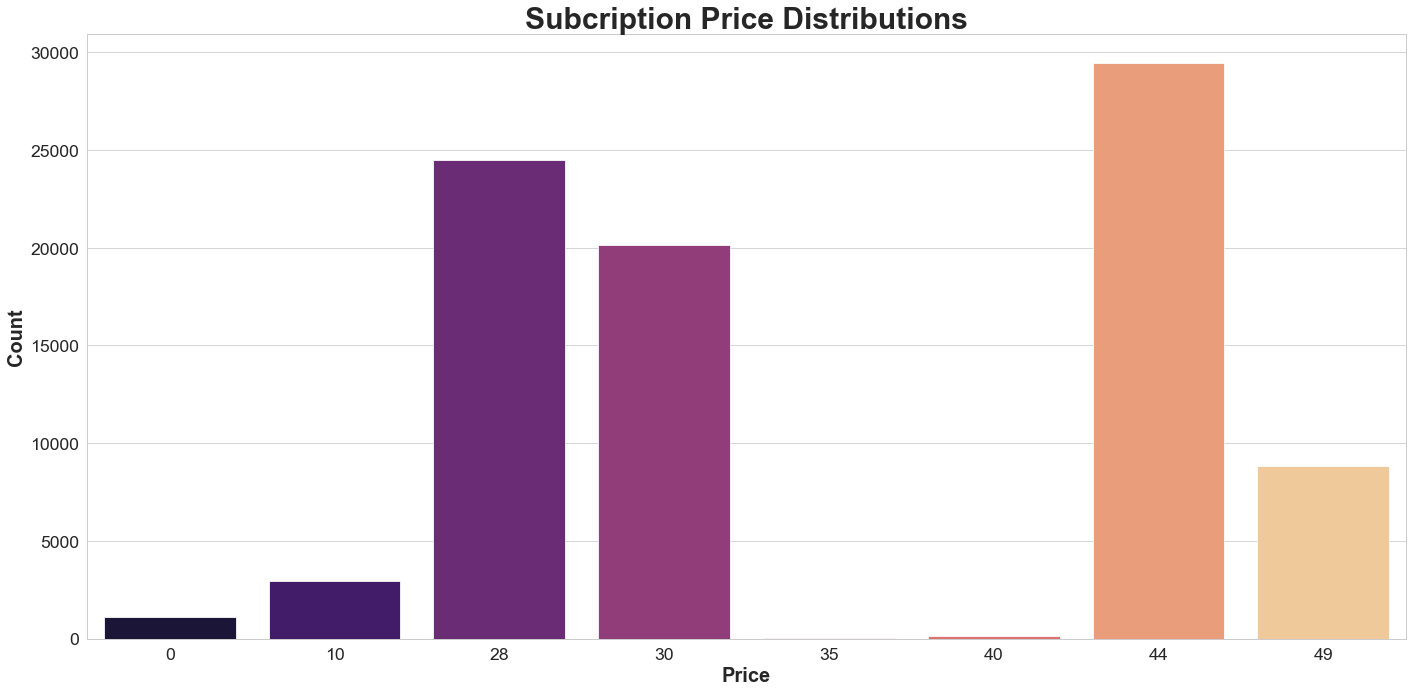

In [41]:
sns.set(style = 'whitegrid')
sns.set_context('paper', font_scale = 2)
sns.set_palette("magma")
fig = plt.figure(figsize = (20, 10))
price = sns.countplot(an13.importo, palette= 'magma')
price.set_xlabel('Price', fontweight = 'bold', fontsize = 20)
price.set_ylabel('Count', fontweight = 'bold', fontsize = 20)
plt.title('Subcription Price Distributions', fontsize = 30, fontweight = 'bold')
plt.tight_layout()

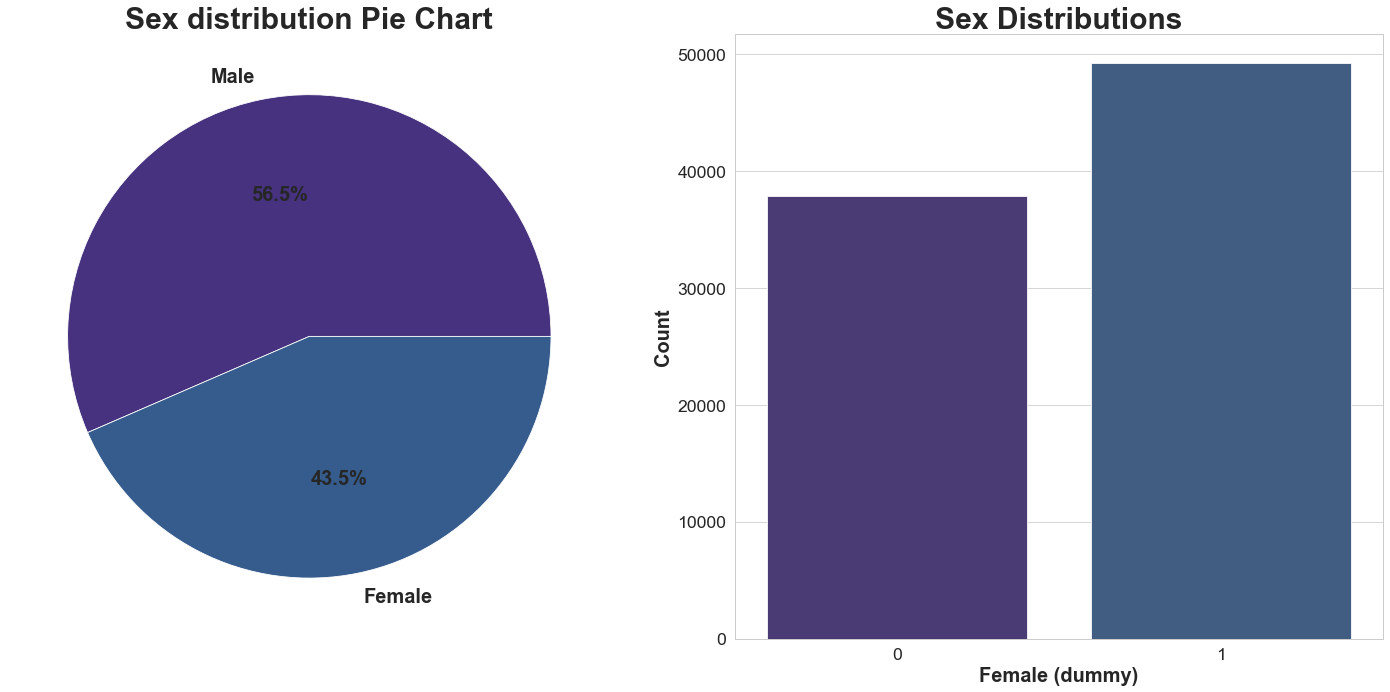

In [87]:
sns.set(style = 'whitegrid', palette = 'viridis')
sns.set_context('paper', font_scale = 2)
fig = plt.figure(figsize = (20, 10))
plt.subplot(121)
plt.pie(an13.femmina.value_counts(),labels = ['Male', 'Female'], autopct = '%.1f%%', radius = 1, textprops={'fontsize': 20, 'fontweight': 'bold'})
plt.title('Sex distribution Pie Chart', fontsize = 30, fontweight = 'bold')
plt.subplot(122)
t = sns.countplot(an13.femmina)
t.set_xlabel('Female (dummy)', fontweight = 'bold', fontsize = 20)
t.set_ylabel('Count', fontweight = 'bold', fontsize = 20)
plt.title('Sex Distributions', fontsize = 30, fontweight = 'bold')
plt.tight_layout()